## Logistic Regression for Qualifiers against Team Survival

### Objectives
Qualifiers could arguably be similar to a dan; of course, the choice of patterning and difficulty are well balanced and executed in the mapping of these charts, but ultimately, it is akin to playing 4-8 maps and seeing who's better at them. 
Beyond seeding, they may not even matter. Or at least, the relationship between good performances in the qualifier vs bracket stage is not well established.

Is it then fair to determine that a 4 digit player is overskilled, because of their performance in the qualifiers? This is the question we attempt to answer today.
- Have the qualifiers, as promised by qualifier mappers and poolers, been able to decently represent the performance of teams across different rounds?
- How does a team's performance in a specific qualifier map affect their chances of advancing to each of the rounds?

In order to answer these questions, we will be extracting the qualifier scores from all teams and their last round of participation, and run a *logistic regression* model over them.

### What is Logistic Regression?
*Logistic Regression* is a statistical method that models the probability of an event taking place, given other independent variables of the observation. This is done by having the *logarithmic* odds of an event happening be mathematically modelled after the independent variables of the observation. 

In this exploratory data analysis, we note that a model has yet to be established; hence, we will be **estimating the parameters of the logistic model** relating each team's qualifier scores to their odds of survival in each round.

### Required Packages

For this data analysis, a couple of libraries and modules are used:
- Standard libraries such as NumPy, Pandas, Matplotlib are needed for pretty much any form of data visualization!
- The Logistic Regression model from sklearn, and its evaluative metric package are also imported.
- the *get_table* function is also imported for an efficient way to handle the tables obtained from the dataset;
- the datasets are imported from the Dataset class, a class created by HowToPlayLN (HowToProgramming) for all data analysis projects performed using 4DM4 data. See the documentation for the Dataset class [here](https://github.com/HowToProgramming/4dm4analysis/blob/main/readme.md).

In [1]:
import os

os.chdir("..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from utils import Dataset
from utils import get_table

### Obtaining the Dataset 
Making use of the Dataset class provided, we will be able to grab all team scores for 4DM4. This is done so by restricting the query to the "team_scores" table. The query is restricted to purely qualifier scores. This will allow each team's combined score on each of the Qualifier stages (excluding SV) to be used as an independent variable that adds to the log-odds of the team clearing a specific round.

We will also be able to extract the dependent variable, which is the last round of participation for every team involved in 4DM4. This is done by accessing the "team_data" table.

In [3]:
_4dm4 = Dataset("datasets/4dm4.db")

def qual_database(lst):
    res = pd.DataFrame()
    for type in lst:
        ds = _4dm4.select(table="team_scores", 
                            columns=["country_name", "round", "beatmap_type", "beatmap_tag", "score", "score_logit"],
                            where={
                                "round": "\"Q\"",
                                "beatmap_type": f"\"{type}\""
                            }
                        )
        res = pd.concat([res, ds])
    return res

interested_types = ["RC", "LN", "HB"]
qual_data = qual_database(interested_types)

team_finalrd = _4dm4.select(table="team_data",
                            columns=["country_name", "country_code", "last_round"])

In [4]:
qual_data

,country_name,round,beatmap_type,beatmap_tag,score,score_logit
0,Argentina,Q,RC,1,2974794,4.770848
1,Argentina,Q,RC,2,2869465,3.090239
2,Australia,Q,RC,1,2981938,5.106518
3,Australia,Q,RC,2,2870047,3.094911
4,Belgium,Q,RC,1,2979151,4.962088
...,...,...,...,...,...,...
34,United Kingdom,Q,HB,1,2939583,3.884752
35,United States,Q,HB,1,2950079,4.079145
36,Uruguay,Q,HB,1,2827684,2.797883
37,Venezuela,Q,HB,1,2911549,3.493992


### Dataset Transformation
Currently, a single country's score on a single stage is populated on each row. However, this is not the format required to fit in the model - We will need the scores for each stage to be populated in a single row, for each country. This is where the 'get_table' function from the inbuilt 'utils' module comes into play; it provides a quick and easy way for us to present the data in this required format for the logistic regression model.

Furthermore, an integer label was introduced to every team that made it past RO16; this is to counter the lack of a timestamp or any form of unbiased X-axis that could possibly represent the scaling of difficulty over each of the rounds.

In [5]:
interested_rds = {"RO16": 1, 
                  "QF": 2, 
                  "SF": 3, 
                  "F": 4, 
                  "GF": 5} #round of 32 is not included, as the 1st bracket stage in double elimination tournament.

#add an integer value to each round with elimination for easier comparison later
team_finalrd["lastrd_int"] = team_finalrd.last_round.map(interested_rds)
team_finalrd.index = team_finalrd["country_name"]
qual_scores_table = get_table(qual_data)

In [6]:
print(qual_scores_table.head(n = 10))

                      Q_RC_1    Q_RC_2    Q_LN_1    Q_HB_1
Argentina           4.770848  3.090239  3.517585  3.044389
Australia           5.106518  3.094911  4.177576  3.840033
Belgium             4.962088  3.183179  3.572762  3.376469
Brazil              5.203850  3.863981  3.768713  3.653680
Canada              5.235430  4.157253  3.866833  3.524540
Chile               4.660182  3.779302  2.945991  2.948777
Denmark             4.608371  3.511907  3.301269  3.044973
Dominican Republic  4.669194  3.315557  3.204884  3.515919
Ecuador             3.885395  3.435464  2.737532  3.179696
Finland             4.159936  3.262274  3.050590  2.830394


In [7]:
print(team_finalrd.head(n = 10))

                          country_name country_code last_round  lastrd_int
country_name                                                              
Argentina                    Argentina           AR       RO16         1.0
Australia                    Australia           AU         QF         2.0
Belgium                        Belgium           BE       RO16         1.0
Brazil                          Brazil           BR          F         4.0
Canada                          Canada           CA          F         4.0
Chile                            Chile           CL       RO16         1.0
Denmark                        Denmark           DK       RO16         1.0
Dominican Republic  Dominican Republic           DO       RO16         1.0
Ecuador                        Ecuador           EC          Q         NaN
Finland                        Finland           FI       RO16         1.0


### Selection of Solvers for Logistic Regression:
With all the data prepared, we can finally proceed with the data analysis. As the super uneducated student as I (Poly) am, I will first experiment with everything we can get our hands dirty with.

So you might question, what is a *solver*?

To put it simply, *solvers* are tools we use in logistic regression. These *solvers* use a variety of methods to solve for the coefficients with the least error in predicting whether an event happens in all observations; Loosely speaking, we will attempt to find a *solver* among the 6 introduced below that provides the highest accuracy in predicting whether each team survives the round in question, and obtain the coefficients attached to each of the team's scores. These coefficients give us an idea of whether the stage in question significantly affects the chances of a team surviving beyond a round. The higher this coefficient is, the more effect the stage has on a team surviving the specific round! 

Now we shall look into each of the 6 solvers. They will be covered in as little detail as required to understand the differences between the performance of each model, and a more specific explanation can be found [here](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions#:~:text=It's%20a%20linear%20classification%20that,coordinate%20directions%20or%20coordinate%20hyperplanes.).

#### L1/L2 Stochastic Average Gradient (SAG), and its Alternate Model (SAGA)
For these 3 models, the Stochastic Average Gradient (SAG) model is used. Like other Stochastic Gradient Descent (SGD) methods, this solver implements an iterative method to solve for the parameters of the model by "smoothening" fluctuations in data points through approximation. Additionally, it also allocates some memory to remember the previous gradient values approximated by the model, so it spends much lesser time calculating and converging to the final solution. This solver is more effective for logistic regression involving a few (sparse) dependent variables, and across a larger dataset.

- It is also to be noted that our dataset for 4DM4 is rather small; this model may in fact not be as effective.

The SAG model also has a variant SAGA, which supports a non-smooth penalty L1 term alongside L2. Both L1 and L2 penalty terms are used to tune and refine a function such that the final coefficients consider extreme values to a much lower extent, increasing its accuracy in predicting the correct parameters. 

In which case, both L1 and L2 penalty terms are attempted because I suck lol.

#### L2 Newton
Newton's Method, on the other hand, solves for the parameters by taking steps closer to the final parameters, through a method that allows the model to be approximated as a quadratic equation. This makes use of both the first and second partial derivatives, utilising the Hessian matrix. This process repeats until the minimum/maximum point is achieved, and parameters are determined.

This method requires more computing power due to the implementation of the Hessian Matrix in its solver. 

#### L2 Limited-memory Broyden-FLetcher-Goldfarb-Shanno (L-BFGS)
The L-BFGS model could be said to be a rehash of the Newton Method. However, the model reverses the computations made by the Hessian Matrix, by using an inverse of itself.

- It is to be noted that this model will not work if the Hessian Matrix is singular (i.e. not invertible).

- This model is however predicted to have the best performance compared to other methods, as it saves up lots of memory on smaller datasets. For our application, this could be the best use case.

#### L2 Large Linear Classification
This Linear Classification model applies L1 Regularization techniques along with linear support vector machines, allowing the solver to work on datasets with higher dimensions (i.e. datasets with more than 3 variables. The more, the better it performs relative to other models.)

- This generally does not run efficiently with the relatively small amount of data obtained for this project.

### Implementation of Models
The models as introduced, will be implemented into the code now.

Furthermore, the hyperparameter C is introduced to the model; This *C hyperparameter* adds a penalty for each misclassified data point.
- If C is larger, the penalty is low so a decision with a large margin for error is introduced at the expense of misclassification. In other words, the model is more forgiving towards misclassifications, but also tends to run foul. A larger C parameter would be more relevant for futureproof models, and could possibly work better if we end up having to deal with scores from participants that we have never seen in the context of a tournament like 4DM.

- If C is smaller, the model is stricter, and classifies better. However, it also runs the risk of 'overtuning' itself to the data already introduced, and may not know how to react when faced with new data that causes breaks in the boundaries of the model's logic. 

In this iteration of the analysis, the C hyperparameter is set to a relatively high penalty value of 10.

In [8]:
#selection of models for logistic regression;
C = 10
classifiers = {
    "L1 logistic": LogisticRegression(
        C=C, penalty="l1", solver="saga", multi_class="ovr", max_iter=10000
    ),
    "L2 logistic (OvR)": LogisticRegression(
        C=C, penalty="l2", solver="saga", multi_class="ovr", max_iter=10000
    ),
    "L2 L-BFGS": LogisticRegression(
        C=C, penalty="l2", solver="lbfgs", multi_class="ovr", max_iter=10000
    ),
    "L2 Newton": LogisticRegression(
        C=C, penalty="l2", solver="newton-cg", multi_class="ovr", max_iter=10000
    ),
    "L2 Large Linear Classification": LogisticRegression(
        C=C, penalty="l2", solver="liblinear", multi_class="ovr", max_iter=10000
    ),
    "L2 Stochastic Average Gradient": LogisticRegression(
        C=C, penalty="l2", solver="sag", multi_class="ovr", max_iter=10000
    )
}

### Analysis
The previously prepared data will now be fit into each of the 6 models.

A couple of functions were implemented to better facilitate the analysis of the model parameters for each round:
- "rd_regression": This takes a round and its corresponding integer. This integer is compared to the last_round integer for each of the teams, and if both integers are the same, the team is declared dead after the round has concluded. 

- A column "alive_afterrd" is also introduced to the data, which will show whether the team survived the round in question (0 for no, and 1 for yes). In which case, if both round integers are the same, a team will be marked a 0, and if the team's last round int is greater, then they are marked a 1. This forms the independent variable the model is supposed to predict.

- for each classifier in the 6 classifier models, the data is fit into the classifier, and the model parameters are yielded and saved into a dataframe for easier viewing and visualization later on.

- The codeline that prints the Coefficient Matrix (a comparison between correct/incorrect Positive and Negative classifications) obtained by running the obtained model across the same data used to train the model (due to very limited size of data obtained) is also included but not run; feel free to uncomment and print this!

In [9]:
#disable warnings that will fill up the output
pd.options.mode.chained_assignment = None

#fit qualiiers scores for each team as X, whether they survived in round (binary 0/1) as Y
def rd_regression(round):
    team_alive = team_finalrd[team_finalrd["lastrd_int"] >= interested_rds[round]-1] #include all teams who advanced to the current round in iteration
    qual_scores_team = qual_scores_table[qual_scores_table.index.isin(team_alive["country_name"].unique().tolist())]
    team_alive["alive_afterrd"] = team_alive.lastrd_int.apply(lambda x: 0 if int(x) == interested_rds[round] else 1)
    team_alive.loc[team_alive["country_name"] == "France", "alive_afterrd"] = 1 #France is technically the only country to advance from GF as the winner of the tournament
    X, y = qual_scores_team, team_alive["alive_afterrd"].ravel()
    X_train, X_test, y_train, y_test = X, X, y, y
    
    #generate table with all exponentiated coefficients for each independent variable i.e. each stage
    fin = pd.DataFrame(columns = ["Round", "Classifier", "Q_RC1", "Q_RC2", "Q_LN1", "Q_HB1", "Intercept"])
    for index, (name, classifier) in enumerate(classifiers.items()):
        res = pd.DataFrame(columns = ["Round", "Classifier", "Q_RC1", "Q_RC2", "Q_LN1", "Q_HB1", "Intercept"])
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
        #print(f"Confusion Matrix: \n{cnf_matrix}")
        coefs_arr = np.exp(classifier.coef_).flatten().tolist()
        coefs_arr.insert(0, name)
        coefs_arr.insert(0, round)
        coefs_arr.append(classifier.intercept_[0])
        res.loc[len(res)] = coefs_arr
        fin = pd.concat([fin, res], axis = 0, ignore_index = True)
    fin.index.rename(f'{round}', inplace=True)
    return fin

### Analysis II
From here, we make use of the 'rd_regression' model to obtain a table including the parameters and intercept of the final model with the least error in predicting the survival rate of each team in 4DM based off their qualifier scores. This is looped through for every round.

The results are available for each of the 6 models included in the analysis; however, after checking their evaluative metrics (making use of the [Coefficient Matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)), both the Newton and L-BFGS solvers better predicted the survival rates of teams across each of the bracket rounds (starting from RO16 as no countries were eliminated before that).

After a discussion with HowToPLayLN, we decided that the Newton model would be more robust in terms of calculation, thus considering the small number of data points in this dataset we decided to have the Newton solver's results be used for the final data analysis.

In [10]:
    
result = pd.DataFrame(columns = ["Round", "Classifier", "Q_RC1", "Q_RC2", "Q_LN1", "Q_HB1", "Intercept"])
for rd in interested_rds:
    models_rd = rd_regression(rd)
    result = pd.concat([result, models_rd], axis = 0, ignore_index = True)

newton = result[result["Classifier"] == "L2 Newton"]

### Data Visualization
The parameters for each of the stages relative to each round is plotted on a line graph:
- Q_RC1 stands for [Antihero [Stage 2: Defiance]](https://osu.ppy.sh/beatmapsets/1665428#mania/3399967),
- Q_RC2 stands for [Fury [Stage 4: Conflagration]](https://osu.ppy.sh/beatmapsets/1665436#mania/3399979),
- Q_LN1 stands for [Transform (Original Mix) [Stage 3: Homeomorphism]](https://osu.ppy.sh/beatmapsets/1665269#mania/3399628),
- Q_HB1 stands for [HIVEMIND [Stage 5: Controlled Chaos]](https://osu.ppy.sh/beatmapsets/1665442#mania/3399992)

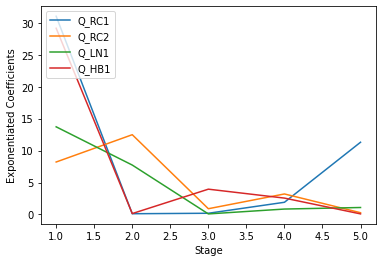

In [11]:
#re-convert rounds to their respective integers for plotting, too lazy to use actual Datetime kappa
newton["Round"] = newton["Round"].map(interested_rds)

plotted_stg = ["Q_RC1", "Q_RC2", "Q_LN1", "Q_HB1"]
for stage in plotted_stg:
    x, y = newton["Round"], newton[f"{stage}"]
    plt.plot(x, y, label = f"{stage}")
    
plt.xlabel("Stage")
plt.ylabel("Exponentiated Coefficients")
plt.legend(loc = "upper left")
plt.show()

### Observations
This is actually an interesting result to behold. There are a couple of reasons why this is pretty unexpected:
- Stage 3 (Q_LN1) is an LN map that tests both versatility in early-game and mid-game density patterns; it's high significance from RO16 to QF makes lots of sense, and is validated by the model as well. Its slow increase in later rounds is slightly interesting, but a future topic for discussion.

- Stage 2 does, in fact, play a huge significance in earlier rounds (highest parameter in RO16 / round int 1). It is after all meant to be the accuracy qualifier; If you had good accuracy and MA ratio on Stage 2, this would have directly translated into a good result in the earlier rounds, such as RO16 (this could have been even higher in RO32).

- However, it is also pretty unexpected that Stage 2's significance in determining if a team wins the tournament is also in the 10s. It is generally expected that the set of parameters gradually decrease as the round integers increase, since qualifiers are designated to only test skillsets in the early-midgame, and play a much smaller significance at later rounds where high scores/ratios take the backseat for consistency and combo skill.

- In fact, Stage 4 (Q_RC2) was expected to be the stage with the highest parameter going into the later rounds. It does peak in significance at QF, which makes some sense since the midgame pools were designated in a way to differentiate teams with players of sufficient endurance levels with decent accuracy.

- On the end of Stage 5 (Q_HB1), it was expected to peak in significance and represent a difficulty between QF and SF. This does seem to be represented in the predicted model parameters, as the parameter value increases from QF to SF, and maintains a stable decrease in value over SF to GF. 

- It is, of course, slightly perplexing that the parameter of Stage 5 on RO16 seemed to match that of Stage 2. This stage is not accuracy-oriented, or mapped in a way for it to be accuracy-friendly. Perhaps it is because the teams who did well on this Stage also had very strong base accuracy, but this is something that could be debatable upon reconcillation with the statistics sheet from 4DM4.

### Conclusions
There are general trends that the logistic regression model with the Newton solver seemed to get right, especially the significance of the stages tallying up well with its intended difficulty initially declared by the charters.

However, some fluctuations towards the later rounds were large, but not unexpected; with much lesser matches happening following each of the later stages, it is pretty difficult for the model to fit with the bigger picture. This could also mean that teams that made it to later rounds would singlehandedly spike/drop the significance of specific stages just based on the qualifier stages they did exceptionally well in. These are unfortunately limitations with the data that can be generated while in the context of a tournament; few matches at the later stages are bound to happen.

### Limitations

As aforementioned, the limited amount of data pertaining to team-based tournaments (and specifically 4DM4) limits the effectiveness of the model as we advance on into later rounds.

- It may be possible to tackle this with dummy data or by collecting more data from possible showmatches between 4DM4 players using each of the pools. On the other hand, a tournament condition for the human is difficult to replicate in a normal practice session (including the presence of nerves, and technical issues), which inherently still poses a problem to data that we could possibly collect to improve the predictions of the model.

### Potential areas of development

This data analysis could be scaled up to no-rank limit tournaments, to expand on the player pool and thus number of scores we could possibly obtain for running the same analysis. Qualifier pools could be compared against one another on the same scale, and grouped into specific difficulty levels and skillsets.

### Thoughts

I hope it was interesting to see me (lowkey) suffer on this analysis. It was really a day's worth of code, with 2-3 days of puzzling about the results with HTPLN. 

If this analysis interests you and you are interested to know how your tournament mappools/operations could benefit from statistical analysis, contact me or HowToPlayLN on Discord for more details :))))

-Poly